In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Util import gen_five_clusters, visualize2d

class NN:
    def __init__(self, ws=None):
        self._ws = ws
        self._n_hiddens = []
        self._funcs, self._loss_func = [], None
    
    @staticmethod
    def relu(x, diff):
        if diff:
            return x != 0
        return np.maximum(0, x)
    
    @staticmethod
    def sigmoid(x, diff):
        if diff:
            return x * (1 - x)
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def tanh(x, diff):
        if diff:
            return (1 - x) * (1 + x)
        return np.tanh(x)
    
    @staticmethod
    def identical(x, diff=False):
        return x
    
    @staticmethod
    def cross_entropy_with_softmax(y_pred, y_true, diff):
        if diff:
            return y_pred - y_true
        exp_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
        exp_pred /= np.sum(exp_pred, axis=1, keepdims=True)
        return -np.average(
            y_true * np.log(np.maximum(y_pred, 1e-12)) +
            (1 - y_true) * np.log(np.maximum(1 - y_pred, 1e-12))
        )
    
    def add(self, func, n_hidden):
        self._funcs.append(func.lower())
        self._n_hiddens.append(n_hidden)
        
    def add_loss(self, loss_func):
        self._funcs.append("identical")
        self._loss_func = loss_func.lower()
    
    def fit(self, x, y, lr=1e-3, epoch=1000):
        input_dim, output_dim = x.shape[1], y.shape[1]
        losses = []
        self._loss_func = getattr(self, self._loss_func)
        self._funcs = [getattr(self, func) for func in self._funcs]
        self._init_weights(x.shape[1], y.shape[1])
        for _ in range(epoch):
            # 计算各层的激活值
            activations = self._get_activations(x)
            # 计算各层的局部梯度
            deltas = [self._loss_func(activations[-1], y, True)]
            for i in range(-1, -len(activations), -1):
                deltas.append(
                    deltas[-1].dot(self._ws[i].T) * 
                    self._funcs[i - 1](activations[i - 1], True)
                )
            # 根据激活值与局部梯度来更新参数
            for i in range(len(activations) - 1, 0, -1):
                self._opt(i, activations[i - 1], deltas[len(activations) - i - 1], lr)
            self._opt(0, x, deltas[-1], lr)
            # 记录损失
            losses.append(self._loss_func(activations[-1], y, False))
        return losses
    
    def _init_weights(self, input_dim, output_dim):
        if self._ws is not None:
            return
        self._ws = []
        current_dim = input_dim
        for n_hidden in self._n_hiddens:
            self._ws.append(np.random.randn(current_dim, n_hidden))
            current_dim = n_hidden
        self._ws.append(np.random.randn(current_dim, output_dim))
    
    def _get_activations(self, x):
        activations = [self._funcs[0](x.dot(self._ws[0]), False)]
        for i, func in enumerate(self._funcs[1:]):
            activations.append(func(
                activations[-1].dot(self._ws[i + 1]), False
            ))
        return activations
    
    def _opt(self, i, activation, delta, lr):
        # 采用朴素的梯度下降法进行训练
        self._ws[i] -= lr * activation.T.dot(delta)
    
    def predict(self, x):
        return np.argmax(self._get_activations(x)[-1], axis=1)

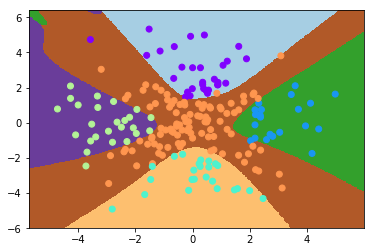

准确率：    97.0 %


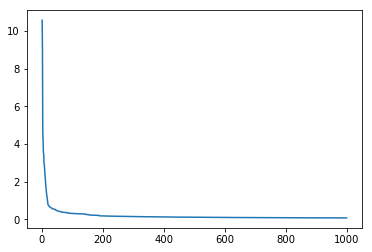

In [2]:
x, y = gen_five_clusters()
label = np.argmax(y, axis=1)

nn = NN()
nn.add("Sigmoid", 64)
nn.add("Sigmoid", 64)
nn.add("Sigmoid", 64)
nn.add("Sigmoid", 64)
nn.add_loss("cross_entropy_with_softmax")

losses = nn.fit(x, y, 1e-4)
visualize2d(nn, x, label, padding=0.2, draw_background=True)
print("准确率：{:8.6} %".format((nn.predict(x) == label).mean() * 100))

plt.figure()
plt.plot(np.arange(1, len(losses)+1), losses)
plt.show()